In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from uedge import *
from uedge.hdf5 import *
#import plotmesh as pm
from uetools import Case
from uedge.gridue import write_gridue
from Forthon import gchange

UEDGE configuration file /Users/eliotfelske/.uetoolsrc read.


# Create Case from YAML

In [4]:
#c = Case('v9_te1000_pi900_n2e20_imp0_last_ii2.hdf5') IGNORE
#c = Case('reconverged_v12_p3.93_n2.38_imp3e2_d0.05_ke0.06_ki0.06_last_ii2.hdf5')
c = Case('input_v12_dif.yaml')
print("dif_use, kye_use, kyi_use around SOL:", bbb.dif_use[30, :, 0][1], bbb.kye_use[30, :][1], bbb.kyi_use[30, :][1])
#if bbb.dif_use[30, :, 0][1] == c_dif and bbb.kye_use[30, :][1] == c_kye and bbb.kyi_use[30, :][1] == c_kyi:
   # pass
#else:
    #print(f'Diffusivities or chi values not matching!', file=sys.stderr)

No diffusivity-file supplied: reading from save-file ".../jupyter/MANTA_final_baseline/reconverged_v12_p3.93_n2.38_imp3e2_d0.05_ke0.06_ki0.08_last_ii2.hdf5"
  User-specified diffusivities read from HDF5 file ".../jupyter/MANTA_final_baseline/reconverged_v12_p3.93_n2.38_imp3e2_d0.05_ke0.06_ki0.08_last_ii2.hdf5"
UETOOLS-style save successfully restored from .../jupyter/MANTA_final_baseline/reconverged_v12_p3.93_n2.38_imp3e2_d0.05_ke0.06_ki0.08_last_ii2.hdf5
*** For isimpon=2, set afracs, not afrac ***

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 1.52e-02

dif_use, kye_use, kyi_use around SOL: 0.05 0.06 0.093


In [3]:
bbb.GridFileName = 'gridmorph2/SUCCESS.hdf5'

In [5]:
c.populate()
print("dif_use, kye_use, kyi_use around SOL:", bbb.dif_use[30, :, 0][1], bbb.kye_use[30, :][1], bbb.kyi_use[30, :][1])

*** For isimpon=2, set afracs, not afrac ***

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 5.35e-02

dif_use, kye_use, kyi_use around SOL: 0.05 0.06 0.1


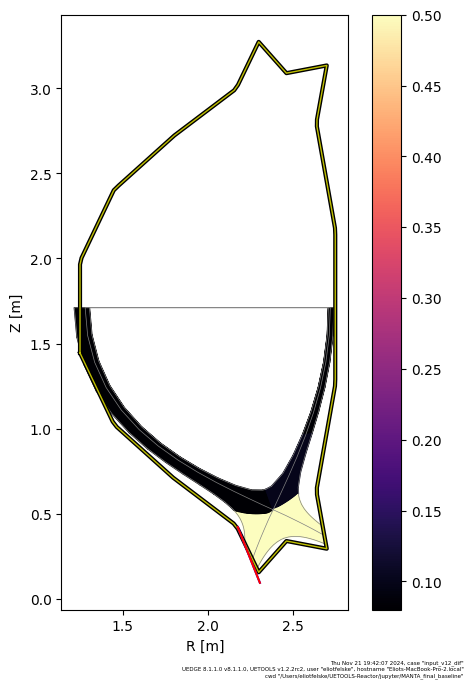

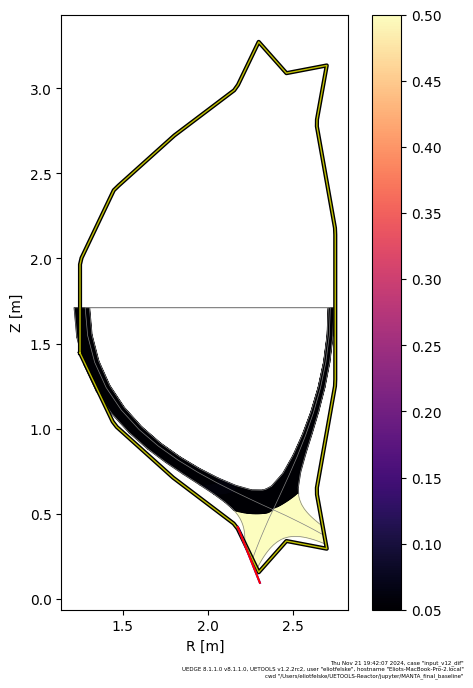

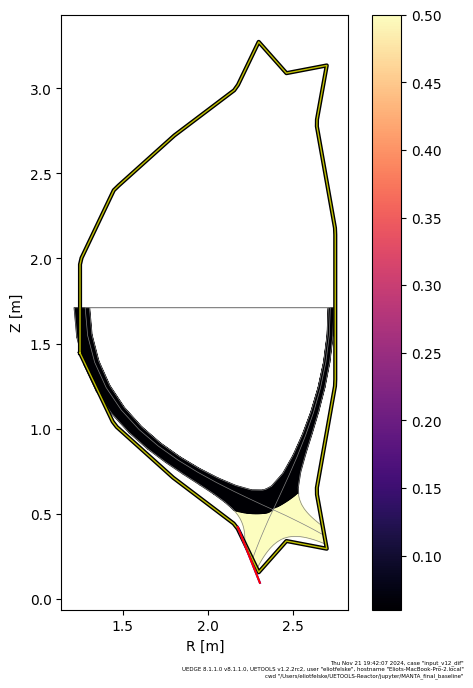

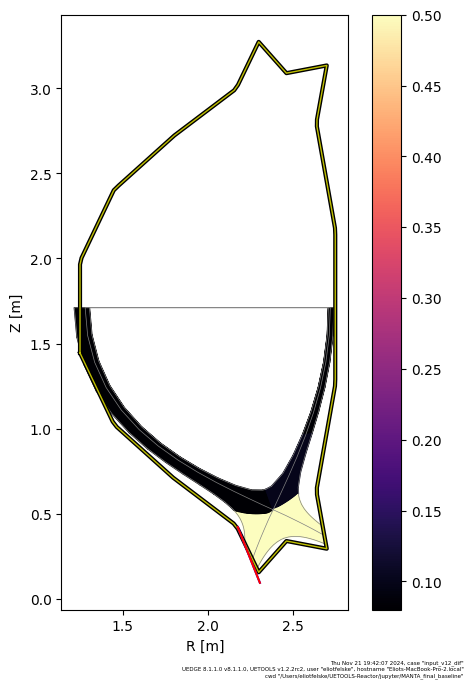

In [5]:
c_dif = 0.05
c_kye = 0.06
c_kyi = 0.08

bbb.dif_use[30,:,0] = [c_dif] * 46
bbb.dif_use[29,:,0] = [c_dif] * 46
bbb.dif_use[28,:,0] = [c_dif] * 46
bbb.dif_use[27,:,0] = [c_dif] * 46
bbb.dif_use[26,:,0] = [c_dif] * 46
bbb.dif_use[25,:,0] = [c_dif] * 46
bbb.dif_use[24,:,0] = [c_dif] * 46
bbb.dif_use[23,:,0] = [c_dif] * 46
bbb.dif_use[22,:,0] = [c_dif] * 46
bbb.dif_use[21,:,0] = [c_dif] * 46
bbb.dif_use[20,:,0] = [c_kye] * 46
bbb.dif_use[19,:,0] = [c_dif] * 46
bbb.dif_use[18,:,0] = [c_dif] * 46
bbb.dif_use[17,:,0] = [c_dif] * 46
bbb.dif_use[31,:,0] = [c_dif] * 46
bbb.dif_use[32,:,0] = [c_dif] * 46
bbb.dif_use[33,:,0] = [c_dif] * 46
bbb.dif_use[34,:,0] = [c_dif] * 46
bbb.dif_use[35,:,0] = [c_dif] * 46
bbb.dif_use[36,:,0] = [c_dif] * 46

bbb.kye_use[30,:] = [c_kye] * 46
bbb.kye_use[29,:] = [c_kye] * 46
bbb.kye_use[28,:] = [c_kye] * 46
bbb.kye_use[27,:] = [c_kye] * 46
bbb.kye_use[26,:] = [c_kye] * 46
bbb.kye_use[25,:] = [c_kye] * 46
bbb.kye_use[24,:] = [c_kye] * 46
bbb.kye_use[23,:] = [c_kye] * 46
bbb.kye_use[22,:] = [c_kye] * 46
bbb.kye_use[21,:] = [c_kye] * 46
bbb.kye_use[20,:] = [c_kye] * 46
bbb.kye_use[19,:] = [c_kye] * 46
bbb.kye_use[18,:] = [c_kye] * 46
bbb.kye_use[17,:] = [c_kye] * 46
bbb.kye_use[31,:] = [c_kye] * 46
bbb.kye_use[32,:] = [c_kye] * 46
bbb.kye_use[33,:] = [c_kye] * 46
bbb.kye_use[34,:] = [c_kye] * 46
bbb.kye_use[35,:] = [c_kye] * 46
bbb.kye_use[36,:] = [c_kye] * 46

bbb.kyi_use[30,:] = [c_kyi] * 46
bbb.kyi_use[29,:] = [c_kyi] * 46
bbb.kyi_use[28,:] = [c_kyi] * 46
bbb.kyi_use[27,:] = [c_kyi] * 46
bbb.kyi_use[26,:] = [c_kyi] * 46
bbb.kyi_use[25,:] = [c_kyi] * 46
bbb.kyi_use[24,:] = [c_kyi] * 46
bbb.kyi_use[23,:] = [c_kyi] * 46
bbb.kyi_use[22,:] = [c_kyi] * 46
bbb.kyi_use[21,:] = [c_kyi] * 46
bbb.kyi_use[20,:] = [c_kyi] * 46
bbb.kyi_use[19,:] = [c_kyi] * 46
bbb.kyi_use[18,:] = [c_kyi] * 46
bbb.kyi_use[17,:] = [c_kyi] * 46
bbb.kyi_use[31,:] = [c_kyi] * 46
bbb.kyi_use[32,:] = [c_kyi] * 46
bbb.kyi_use[33,:] = [c_kyi] * 46
bbb.kyi_use[34,:] = [c_kyi] * 46
bbb.kyi_use[35,:] = [c_kyi] * 46
bbb.kyi_use[36,:] = [c_kyi] * 46

c.plot.mesh(bbb.dif_use[:,:,0])
c.plot.mesh(bbb.kye_use[:,:])
c.plot.mesh(bbb.kyi_use[:,:])

#indexing first index from 1 starts at the inner plate moving upward with index number, starting at
#Core boundary indicies: HFS: 17-30, LFS: 31-40
#kye biases heat outer plate, dif is more inner plate and has more of an effecto on midplane temps

#for ix in range(com.ixpt1[0]+1,com.ixpt2[0]: bbb.dif_use[ix,:,0]= [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
#len bbb.dif_use[#,:,0] = 46

#for ix in range(com.ixpt1[0] + 1, com.ixpt2[0]):
    #print(bbb.dif_use[ix,:,0])

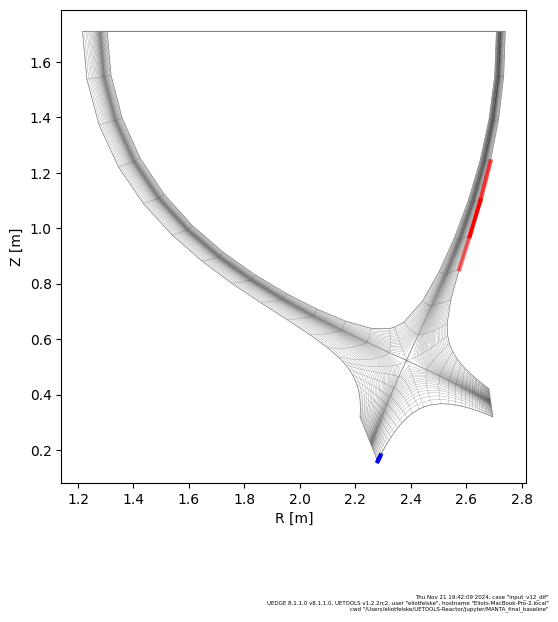

In [6]:
from plot_sinksource import plot_sinksource
plot_sinksource(c)

# Converge

In [7]:
import subprocess
bbb.isbcwdt=0
proc = subprocess.Popen(['caffeinate', "-d", "-u", "-i", "-s"])

try:
    c.converge(savefname='reconverged_v12_p3.93_n2.38_imp3e2_d0.05_ke0.06_ki0.081', dtreal=1e-10)
    os.system("printf '\7'") #macos plays sound after converging
finally:
    # Terminate caffeinate
    proc.terminate()

Requested save-path ../solutions not found, writing to cwd!
*----------------------------------------------------------*
 Need to take initial step with Jacobian; trying to do here 
*----------------------------------------------------------*
*** For isimpon=2, set afracs, not afrac ***
 Reading grid data from /Users/eliotfelske/UETOOLS-Reactor/jupyter/MANTA_final_baseline/gridue_v12_vertical.hdf5
 Grid data read successfully:
     file name:   /Users/eliotfelske/UETOOLS-Reactor/jupyter/MANTA_final_baseline/gridue_v12_vertical.hdf5
     run-ID:      TokaMaker:                                                  
  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.1110921260902032E-01 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.1786393448065842E-04 nfe=      4


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root

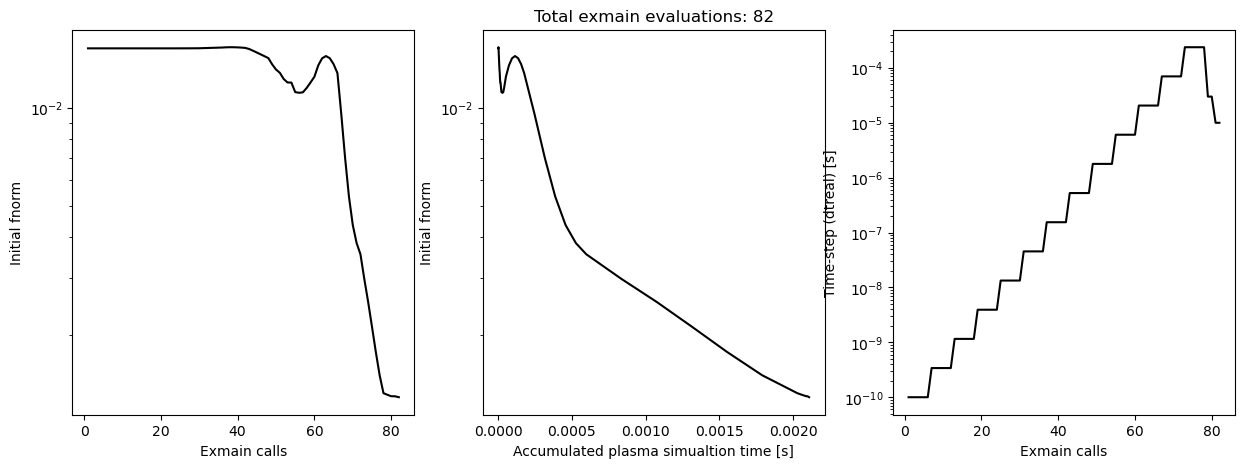

In [4]:
c.solver.convergenceanalysis('reconverged_v12_p3.93_n2.38_imp3e3_d0.05_ke0.06_ki0.1_last_ii2.hdf5');

# Inner plate

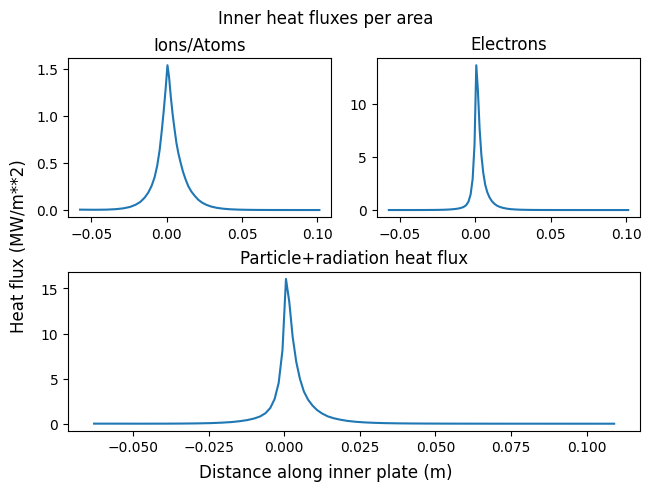

In [9]:
# %matplotlib widget
fig, axs = plt.subplot_mosaic(
    [['TopLeft', 'TopRight'],
     ['Bottom', 'Bottom']],
    layout='constrained',  # Automatically adjust layout
    width_ratios=[1, 1],   # Equal width for the top plots
)
fig.suptitle('Inner heat fluxes per area')
fig.supxlabel('Distance along inner plate (m)')
fig.supylabel('Heat flux (MW/m**2)')
# axs['TopRight'].set_xlabel("Distance along inner plate (m)")
#axs['TopRight'].set_ylabel("feex (W)")
axs['TopRight'].set_title("Electrons")
axs['TopRight'].plot(com.yylb[1:-1],bbb.sdelb[1:-1,0]*1e-6)

# axs['TopLeft'].set_xlabel("Distance along inner plate (m)")
# axs['TopLeft'].set_ylabel("Heat flux (MW/m**2)")
axs['TopLeft'].set_title("Ions/Atoms")
axs['TopLeft'].plot(com.yylb[1:-1],bbb.sdilb[1:-1]*1e-6) #polodal east field area

bbb.fqp=0
bbb.plateflux(); #internally calculated fluxes (postprocessing)
# axs['Bottom'].set_xlabel("Distance along inner plate (m)")
# axs['Bottom'].set_ylabel("Heat flux [MW/m**2]")
axs['Bottom'].set_title("Particle+radiation heat flux")
axs['Bottom'].plot(com.yylb,1.e-6*(bbb.sdtlb+bbb.sdrlb))
plt.show()

# Length Scale Calculations

[[ 2.74460202e-06 -4.56956611e-02]
 [-4.56956611e-02  1.20534256e+03]]
[ 4.24116597e-02 -6.56304021e+02]


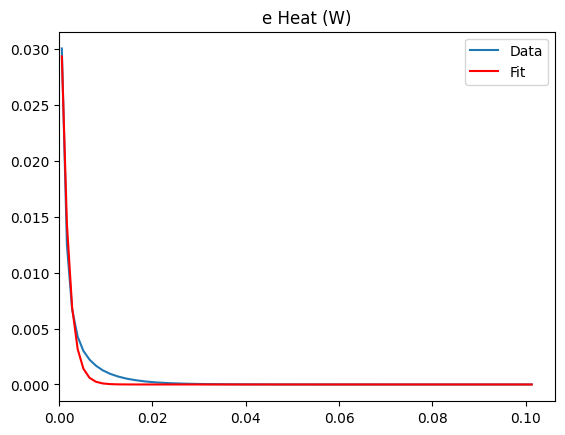

Lambda_q estimate: 1.5236840967756309 mm
[[ 1.73625728e-08 -5.24683504e-04]
 [-5.24683504e-04  3.05945010e+01]]
[ 6.24956235e-03 -1.66786780e+02]


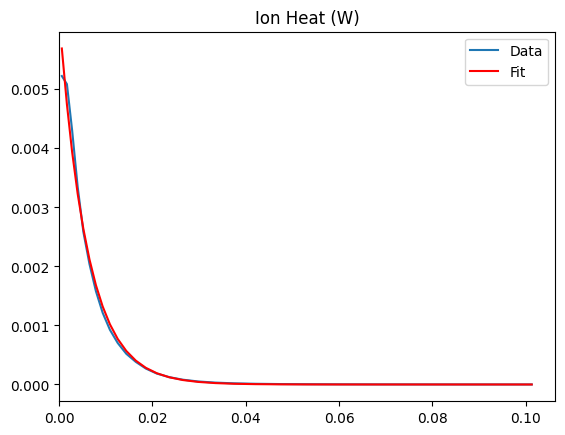

Lambda_q estimate: 5.99567902030864 mm
95.0% of heat flux at x = 2.092cm, Ion temp = 246.683 eV


ValueError: operands could not be broadcast together with shapes (27,) (44,) 

In [10]:
#lambda_q from Eich = 1.06mm (we are probably a bit wider, so I am targeting 1.1mm, lambda_t = 3
from scipy.optimize import curve_fit
# NEED: ION HEAT, ELECTRON HEAT, ION DENSITY
poloidal_index = 28 # CHANGE TO 28 for in board, 32 out board
# exponential fit

#ELECTRONS HEAT 
eheat = -np.array(bbb.feex[poloidal_index,1:-1]/com.sy[poloidal_index,1:-1]*1e-6) #add a minus sign for inboard
dist = np.array([val[0] for val in com.yylb[1:-1]])
mask = dist >= 0
eheat = eheat[mask]
dist = dist[mask]
# Params[0]=a, params[1]=b
# b=-1/lambda_q
params, pcov = curve_fit(lambda t,a,b: a*np.exp(b*t),  dist,  eheat,  p0=(0.5, -1))
print(pcov)
print(params)
y_fit = params[0]*np.exp(params[1]*dist)
# print(y_fit)
# Plot the results
plt.plot(dist, eheat, label="Data")
plt.title("e Heat (W)")
plt.plot(dist, y_fit, 'r-', label="Fit")
plt.gca().set_xlim(left=0)
# plt.axhline(y=0.0, color='r', linestyle='-')
plt.legend()
plt.show()
print(f"Lambda_q estimate: {-1/params[1]*1000} mm")

# IONS HEAT
ionheat = -np.array(bbb.feix[poloidal_index,1:-1]/com.sy[poloidal_index,1:-1]*1e-6) #add a minus sign for inboard
dist = np.array([val[0] for val in com.yylb[1:-1]])
mask = dist >= 0
ionheat = ionheat[mask]
dist = dist[mask]
# Params[0]=a, params[1]=b
# b=-1/lambda_q
params, pcov = curve_fit(lambda t,a,b: a*np.exp(b*t),  dist,  ionheat,  p0=(0.5, -1))
print(pcov)
print(params)
y_fit = params[0]*np.exp(params[1]*dist)
# print(y_fit)
# Plot the results
plt.plot(dist, ionheat, label="Data")
plt.title("Ion Heat (W)")
plt.plot(dist, y_fit, 'r-', label="Fit")
plt.gca().set_xlim(left=0)
# plt.axhline(y=0.0, color='r', linestyle='-')
plt.legend()
plt.show()
print(f"Lambda_q estimate: {-1/params[1]*1000} mm")


# calc 99% heat flux
# ION TEMP REGION
from scipy.integrate import simpson
totalheat = simpson(ionheat, x=dist)
from scipy.integrate import cumulative_trapezoid
cumulative_integral = cumulative_trapezoid(ionheat, dist, initial=0)
target_scale = 0.95
target_value = target_scale * totalheat


index = np.searchsorted(cumulative_integral, target_value)
decaylen = dist[index]
poloidal_index = 29
iontemp= np.array(bbb.ti[poloidal_index,1:-1]/bbb.ev)
print(f"{target_scale*100}% of heat flux at x = {(decaylen*100):.3f}cm, Ion temp = {iontemp[index]:.3f} eV")

tparams, tpcov = curve_fit(lambda t,a,b: a*np.exp(b*t),  dist,  iontemp,  p0=(0.5, -1))

targeteV = 10
iev = np.searchsorted(iontemp[::-1], targeteV, side = "right")*-1

print(f"{targeteV}ev at x = {dist[iev]*100}cm")
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("eV")
plt.title("Ion temp")
plt.plot(com.yylb[1:-1],bbb.ti[33,1:-1]/bbb.ev)
plt.axhline(y=5, color='r', linestyle='-')
plt.gca().set_xlim(left=0)
plt.yscale('log') 
plt.show()

#rint(f"Lambda_t estimate: {-1/tparams[1]*1000} mm")

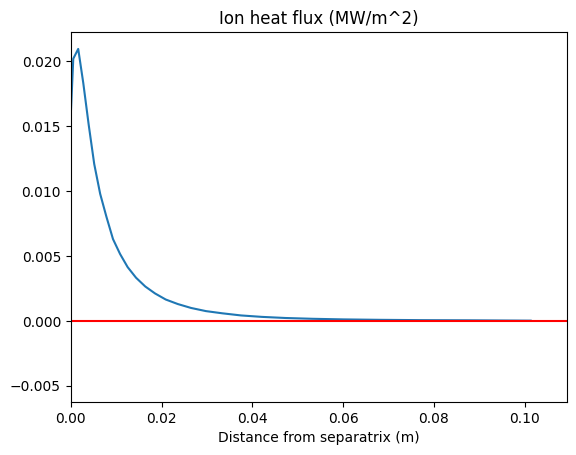

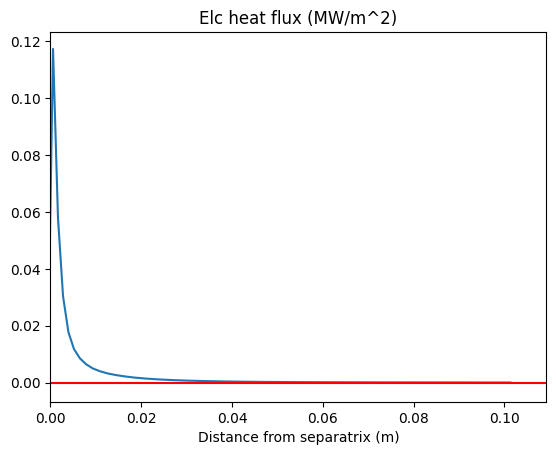

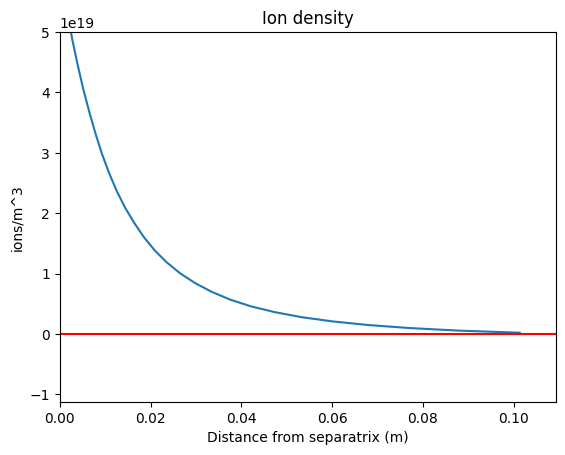

In [11]:
# Some more plots
plt.xlabel("Distance from separatrix (m)")
plt.title("Ion heat flux (MW/m^2)")
ionheat = bbb.feix[33,1:-1]/com.sy[33,1:-1]*1e-6
dist = com.yylb[1:-1]
plt.plot(com.yylb[1:-1],bbb.feix[33,1:-1]/com.sy[33,1:-1]*1e-6)
plt.gca().set_xlim(left=0)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.title("Elc heat flux (MW/m^2)")
plt.plot(com.yylb[1:-1],bbb.feex[33,1:-1]/com.sy[33,1:-1]*1e-6)
plt.gca().set_xlim(left=0)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("ions/m^3")
plt.title("Ion density")


plt.plot(com.yylb[1:-1],bbb.ni[33,1:-1,0])
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(top=0.5e20)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()

# Midplane

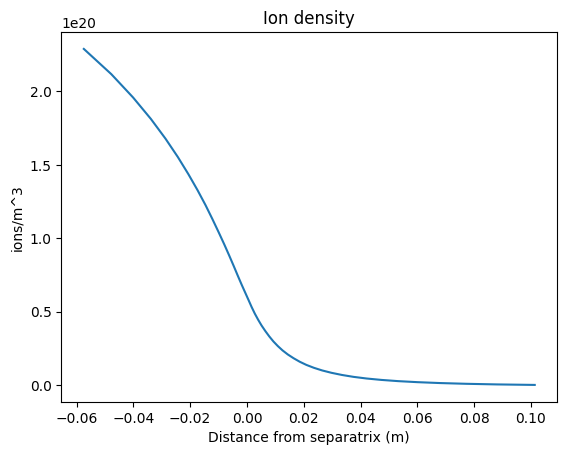

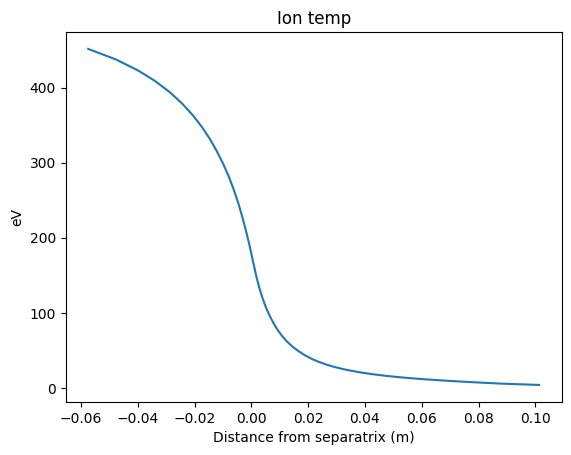

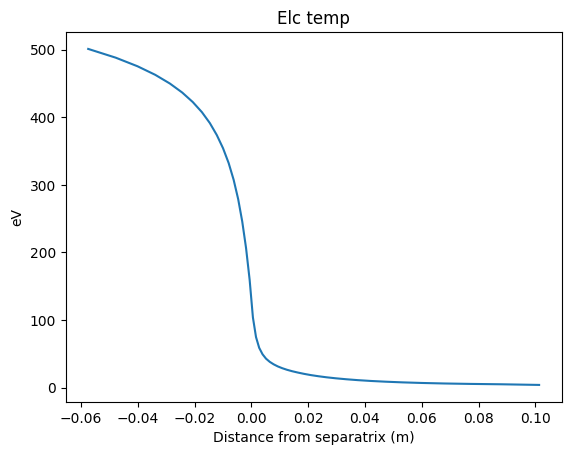

'\nrad = [arr[0] for arr in com.rm[bbb.ixmp, 1:-1]] #average index 2 and 4 for arr\n\nplt.xlabel("R (m)")\nplt.ylabel("Te (eV)")\nplt.title("Te at midplane (ixmp)")\nplt.plot(rad,bbb.te[bbb.ixmp,1:-1]/bbb.ev)\nplt.show()\nplt.xlabel("R (m)")\nplt.ylabel("feex (W/m^2)")\nplt.title("feex outer bound above x point (ixpt2)")\nplt.plot(rad,bbb.feex[com.ixpt2[0],1:-1])\nplt.show()\n\nimport numpy as np\nfrom scipy.optimize import curve_fit\nimport matplotlib.pyplot as plt\n\ndef exponential_func(x, n, k):\n    return np.exp(n - x / k)\n\nx_data = rad\ny_data = bbb.feex[com.ixpt2[0], 1:-1]\n\nx_data_outward = x_data[17:30]\ny_data_outward = y_data[17:30]\n\ntry:\n    popt, pcov = curve_fit(exponential_func, x_data_outward, y_data_outward, p0=[np.log(y_data_outward[0]), 1], maxfev=10000)\n    \n    plt.xlabel("R (m)")\n    plt.ylabel("feex (W/m^2)")\n    plt.title("feex outer bound above x point (ixpt2)")\n    plt.plot(x_data, y_data, label="Data")\n    x_fit = np.linspace(min(x_data_outward),

In [12]:
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("ions/m^3")
plt.title("Ion density")
plt.plot(com.yylb[1:-1],bbb.ni[33,1:-1,0])
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("eV")
plt.title("Ion temp")
plt.plot(com.yylb[1:-1],bbb.ti[33,1:-1]/bbb.ev)
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("eV")
plt.title("Elc temp")
plt.plot(com.yylb[1:-1],bbb.te[33,1:-1]/bbb.ev)
plt.show()

#inner limit of dist. from separatrix should correspond with the rho coord of temp and n BC so rho * minor rad. (0.72m)
#rho=0.92

'''#for heat flux wall mapping fix with Filippo's method
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("feix (W/m^2)")
plt.title("Ion temp * Bpol/Btot")
plt.plot(com.yylb[1:-1],bbb.ti[com.ixpt2[0],1:-1].T/bbb.ev*((com.bpol[com.ixpt2[0],1:-1,0]/com.b[com.ixpt2[0],1:-1,0])))
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("feex (W/m^2)")
plt.title("Elc temp * Bpol/Btot")
plt.plot(com.yylb[1:-1],bbb.te[com.ixpt2[0],1:-1].T/bbb.ev*((com.bpol[com.ixpt2[0],1:-1,0]/com.b[com.ixpt2[0],1:-1,0])))
plt.show()'''
'''
#For length scale need real distance from separatrix at midplane

plt.xlabel("Distance from separatrix (m)")
plt.ylabel("ions/m^3")
plt.title("Ion density ixpt2")
plt.plot(com.yylb[1:-1],bbb.ni[com.ixpt2[0],1:-1])
plt.show()
'''
'''plt.xlabel("R (m)")
plt.ylabel("Ti (eV)")
plt.title("Ti at midplane (ixmp)")
plt.plot(rad,bbb.ti[bbb.ixmp,1:-1]/bbb.ev)
plt.show()'''
'''
rad = [arr[0] for arr in com.rm[bbb.ixmp, 1:-1]] #average index 2 and 4 for arr

plt.xlabel("R (m)")
plt.ylabel("Te (eV)")
plt.title("Te at midplane (ixmp)")
plt.plot(rad,bbb.te[bbb.ixmp,1:-1]/bbb.ev)
plt.show()
plt.xlabel("R (m)")
plt.ylabel("feex (W/m^2)")
plt.title("feex outer bound above x point (ixpt2)")
plt.plot(rad,bbb.feex[com.ixpt2[0],1:-1])
plt.show()

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def exponential_func(x, n, k):
    return np.exp(n - x / k)

x_data = rad
y_data = bbb.feex[com.ixpt2[0], 1:-1]

x_data_outward = x_data[17:30]
y_data_outward = y_data[17:30]

try:
    popt, pcov = curve_fit(exponential_func, x_data_outward, y_data_outward, p0=[np.log(y_data_outward[0]), 1], maxfev=10000)
    
    plt.xlabel("R (m)")
    plt.ylabel("feex (W/m^2)")
    plt.title("feex outer bound above x point (ixpt2)")
    plt.plot(x_data, y_data, label="Data")
    x_fit = np.linspace(min(x_data_outward), max(x_data_outward), 100)
    y_fit = exponential_func(x_fit, *popt)
    plt.plot(x_fit, y_fit, 'r--', label="Exponential Fit")
    plt.legend()
    plt.show()

except RuntimeError as e:
    print("Curve fitting did not converge:", e)

n_opt, k_opt = popt
print(f"Optimized n: {n_opt}")
print(f"Optimized k: {k_opt*1000}") 

bbb.afracs'''


# Outer plate

<Figure size 640x480 with 0 Axes>

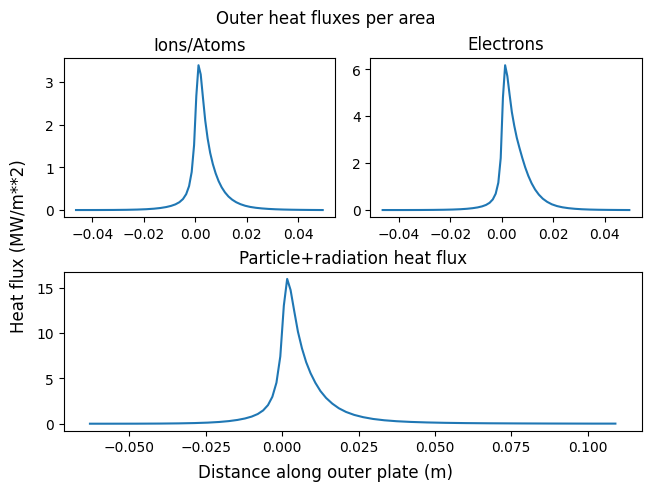

array([15.96143736])

In [13]:
# total convective and conductive heat flux
# 2nd char: e for energy n for particle
plt.figure()
fig, axs = plt.subplot_mosaic(
    [['TopLeft', 'TopRight'],
     ['Bottom', 'Bottom']],
    layout='constrained',  # Automatically adjust layout
    width_ratios=[1, 1],   # Equal width for the top plots
)
fig.suptitle('Outer heat fluxes per area')
fig.supxlabel('Distance along outer plate (m)')
fig.supylabel('Heat flux (MW/m**2)')
# axs['TopRight'].set_xlabel("Distance along inner plate (m)")
#axs['TopRight'].set_ylabel("feex (W)")
axs['TopRight'].set_title("Electrons")
axs['TopRight'].plot(com.yyrb[1:-1],bbb.sderb[1:-1,0]*1e-6)

# axs['TopLeft'].set_xlabel("Distance along inner plate (m)")
# axs['TopLeft'].set_ylabel("Heat flux (MW/m**2)")
axs['TopLeft'].set_title("Ions/Atoms")
axs['TopLeft'].plot(com.yyrb[1:-1],bbb.sdirb[1:-1,0]*1e-6) #polodal east field area

bbb.fqp=0
bbb.plateflux(); #internally calculated fluxes (postprocessing)
# axs['Bottom'].set_xlabel("Distance along inner plate (m)")
# axs['Bottom'].set_ylabel("Heat flux [MW/m**2]")
axs['Bottom'].set_title("Particle+radiation heat flux")
axs['Bottom'].plot(com.yylb,1.e-6*(bbb.sdtrb+bbb.sdrrb))
plt.show()
max(1.e-6*(bbb.sdtrb+bbb.sdrrb))

# 2D Plots


<Figure size 640x480 with 0 Axes>

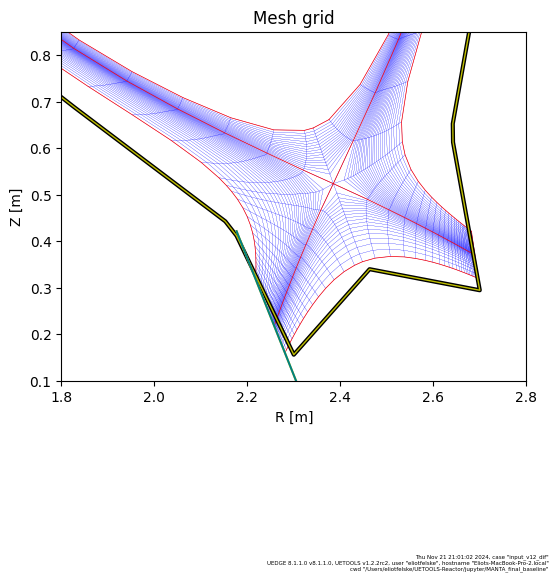

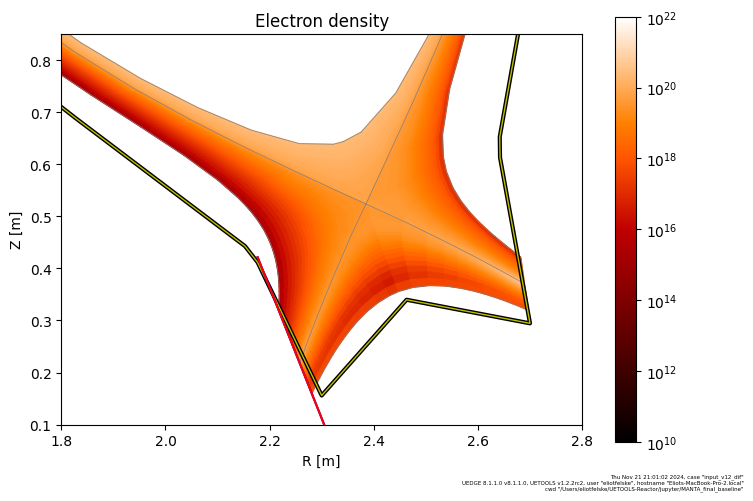

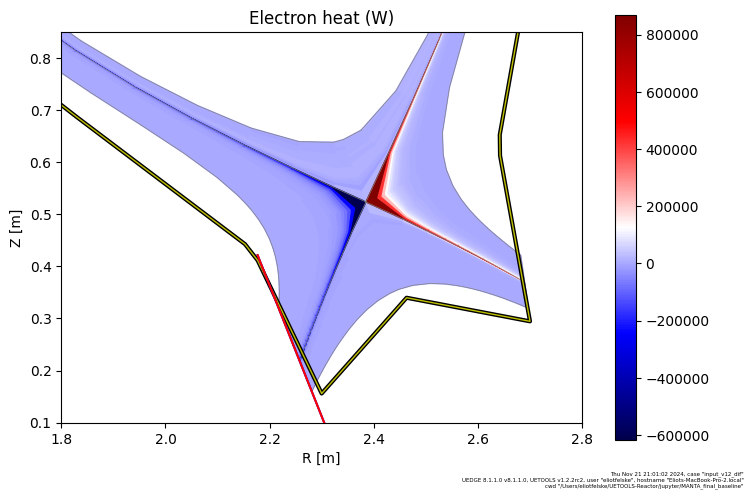

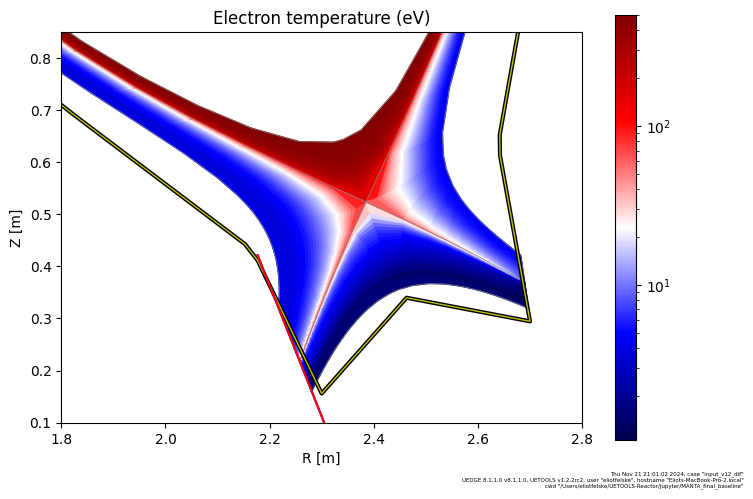

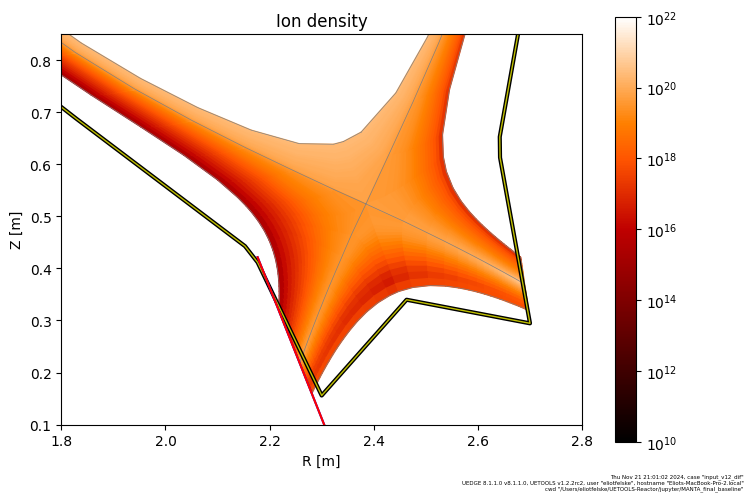

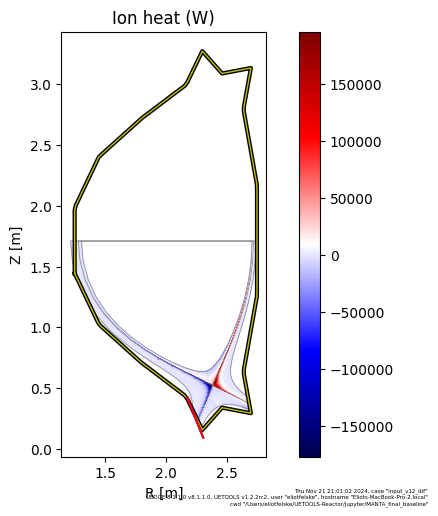

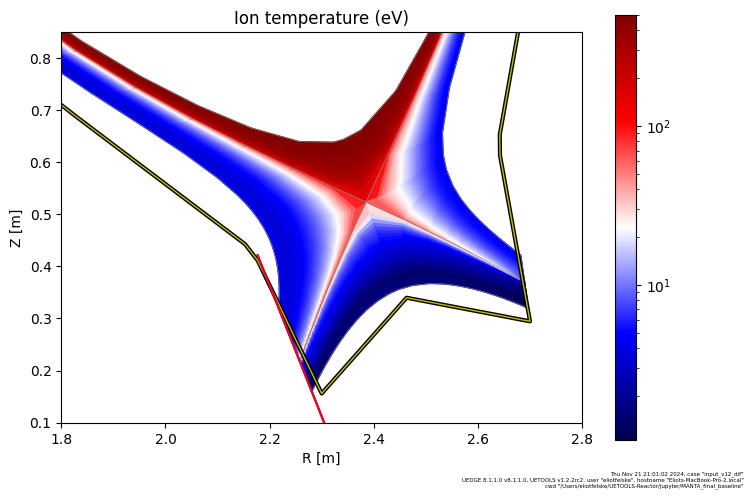

In [14]:
plt.figure()

c.plot.grid(linewidth=0.1, #grid plot
   vessel=True, 
   plates=True, 
   platecolor=['gold','teal'], 
   lcfs=True, 
   xlim=(1.8, 2.8), 
   ylim=(0.1,0.85),
   lcfscolor='r', 
   linecolor='b',
   title='Mesh grid'
  );

c.plot.mesh(
    bbb.ne, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    zrange=(1e10,1e22), 
    cmap='gist_heat',
    title='Electron density'
);


c.plot.mesh(
    bbb.feex, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-8e5,8e5),
    cmap='seismic',
    title='Electron heat (W)'
);
c.plot.mesh(
    bbb.te/bbb.ev, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-5e5,5e5),
    cmap='seismic',
    title='Electron temperature (eV)'
);

c.plot.mesh(
    bbb.ne, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    zrange=(1e10,1e22), 
    cmap='gist_heat',
    title='Ion density'
);
c.plot.mesh(
    bbb.feix, 
    # xlim=(1.8, 2.8), 
    # ylim=(0.1,0.85),
    figsize=(7,5), 
    # zrange=(-8e5,8e5),
    cmap='seismic',
    title='Ion heat (W)'
);
c.plot.mesh(
    bbb.te/bbb.ev, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-5e5,5e5),
    cmap='seismic',
    title='Ion temperature (eV)'
);
plt.show()

In [43]:
c.dashboard() # a GUI with all the most common variable

2024-11-21 14:50:48.661 python[5298:4120264] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-21 14:50:48.661 python[5298:4120264] +[IMKInputSession subclass]: chose IMKInputSession_Modern


# Power Calculations

In [25]:
c = Case('reconverged_v12_p3.93_n2.38_imp3e3_d0.05_ke0.06_ki0.1_last_ii2.hdf5')

Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../jupyter/MANTA_final_baseline/reconverged_v12_p3.93_n2.38_imp3e3_d0.05_ke0.06_ki0.1_last_ii2.hdf5
  User-specified diffusivities read from HDF5 file ".../jupyter/MANTA_final_baseline/reconverged_v12_p3.93_n2.38_imp3e3_d0.05_ke0.06_ki0.1_last_ii2.hdf5"
UETOOLS-style save successfully restored from .../jupyter/MANTA_final_baseline/reconverged_v12_p3.93_n2.38_imp3e3_d0.05_ke0.06_ki0.1_last_ii2.hdf5
*** For isimpon=2, set afracs, not afrac ***

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 4.93e-03



In [15]:
from scipy.integrate import simpson
bbb.fqp=0
bbb.plateflux();

psep = simpson( (bbb.feiy+bbb.feey)[com.ixpt1[0]+1:com.ixpt2[0],com.iysptrx]) / 1e6
pcore = simpson( (bbb.feiy+bbb.feey)[com.ixpt1[0]+1:com.ixpt2[0],0]) / 1e6

print(f' Power from core boundary (surface closest to magnetic axis) = {pcore:.3f} MW  \n \
Power at Separatrix = {psep:.3f} MW  \n \
Power radiated in core region = {(pcore-psep):.3f} MW = {(((pcore-psep)/pcore)*100):3f}%')
particlecore = simpson( (bbb.fniy)[com.ixpt1[0]+1:com.ixpt2[0],0])
particlecore

 Power from core boundary (surface closest to magnetic axis) = 7.891 MW  
 Power at Separatrix = 5.237 MW  
 Power radiated in core region = 2.654 MW = 33.634818%


array([2.05200519e+19, 7.93209646e+19, 1.47593180e+20, 2.66015071e+20,
       2.89557027e+20, 3.27250950e+20, 3.41238831e+20, 3.30887678e+20,
       3.07211492e+20, 2.83766906e+20, 2.65568606e+20, 2.53898901e+20,
       2.45515081e+20, 1.53286795e+15, 6.81102953e+15, 1.09814173e+21,
       1.04123742e+21, 9.38317065e+20, 7.89114719e+20, 6.25725773e+20,
       4.56094285e+20, 2.46688384e+20, 1.51280790e+20])

In [ ]:
impFracs = [1e-4, 3e-3, 3e-2]
pRads = [33.11, 33.9, 42.5]

In [84]:
c.search.var("feex")
c.search.var("sdrrb")

Package:    bbb
Group:      Comflo
Attributes: Comflo 
Dimension:  (0:nx+1,0:ny+1)
            (66, 46)
Type:       double
Address:    5502132224
Pyaddress:  4743690832
Unit:       J/s
Comment:
poloidal electron thermal current,
east face
Package:    bbb
Group:      Postproc
Attributes: Postproc 
Dimension:  (0:ny+1,1:nxpt)
            (46, 1)
Type:       double
Address:    4955692592
Pyaddress:  4743649424
Unit:       W/m**2
Comment:
tot rad flux to right div


In [19]:
print(grd.rplate1,grd.rplate2,grd.zplate1,grd.zplate1)

[2.177 2.307] [2.177 2.307] [0.42138276 0.09438276] [0.42138276 0.09438276]
